In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
import keras
import h5py
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import CSVLogger,ModelCheckpoint
from keras.optimizers import Adam, Adamax
from keras.models import Model, load_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dense, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, GlobalMaxPool2D, add
from tensorflow.keras import backend as K
from tqdm.notebook import tqdm
import tensorflow as tf

2024-04-20 16:38:57.844089: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-20 16:38:57.844196: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-20 16:38:57.952415: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def dice_coef(y_true, y_pred, smooth=100):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    intersection = K.sum(y_true_flatten * y_pred_flatten)
    union = K.sum(y_true_flatten) + K.sum(y_pred_flatten)
    return (2 * intersection + smooth) / (union + smooth)

def dice_loss(y_true, y_pred, smooth=100):
    return -dice_coef(y_true, y_pred, smooth)

def iou_coef(y_true, y_pred, smooth=100):
    intersection = K.sum(y_true * y_pred)
    sum = K.sum(y_true + y_pred)
    iou = (intersection + smooth) / (sum - intersection + smooth)
    return iou

In [3]:
x_train = np.load("/kaggle/input/amd-oct-npy/x_train.npy")[:1000]

In [4]:
y_train = np.load("/kaggle/input/amd-oct-npy/y_train.npy")[:1000]

In [5]:
x_val = np.load("/kaggle/input/amd-oct-npy/x_val.npy")

In [6]:
y_val = np.load("/kaggle/input/amd-oct-npy/y_val.npy")

In [7]:
x_test = np.load("/kaggle/input/amd-oct-npy/x_test.npy")

In [8]:
y_test = np.load("/kaggle/input/amd-oct-npy/y_test.npy")

In [9]:
def unet(input_size):
#     strategy=tf.distribute.MirroredStrategy()
#     with strategy.scope():
    inputs = Input(input_size)

    conv1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(inputs)
    bn1 = Activation("relu")(conv1)
    conv1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation("relu")(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(pool1)
    bn2 = Activation("relu")(conv2)
    conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation("relu")(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(pool2)
    bn3 = Activation("relu")(conv3)
    conv3 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation("relu")(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(pool3)
    bn4 = Activation("relu")(conv4)
    conv4 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation("relu")(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), padding="same")(pool4)
    bn5 = Activation("relu")(conv5)
    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), padding="same")(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation("relu")(bn5)

    """ Now UpConvolution / Decoder Leg will begin, so start with Conv2DTranspose
    The gray arrows (in the above image) indicate the skip connections that concatenate the encoder feature map with the decoder, which helps the backward flow of gradients for improved training. """
    """ After every concatenation we again apply two consecutive regular convolutions so that the model can learn to assemble a more precise output """

    up6 = concatenate([Conv2DTranspose(512, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn5), conv4], axis=3)
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(up6)
    bn6 = Activation("relu")(conv6)
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation("relu")(bn6)

    up7 = concatenate([Conv2DTranspose(256, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn6), conv3], axis=3)
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(up7)
    bn7 = Activation("relu")(conv7)
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation("relu")(bn7)

    up8 = concatenate([Conv2DTranspose(128, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn7), conv2], axis=3)
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(up8)
    bn8 = Activation("relu")(conv8)
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation("relu")(bn8)

    up9 = concatenate([Conv2DTranspose(64, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn8), conv1], axis=3)
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(up9)
    bn9 = Activation("relu")(conv9)
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation("relu")(bn9)

    conv10 = Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid")(bn9)

    model = Model(inputs=[inputs], outputs=[conv10])
    return model

In [10]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((1000, 256, 256, 3),
 (1000, 256, 256, 3),
 (200, 256, 256, 3),
 (200, 256, 256, 3))

In [11]:
def fun(y_data):
    y=[]
    for i,img in enumerate(y_data):
        img=np.mean(img,axis=2)
        y += [np.float32(np.resize(img,(256,256,1)))]
    return np.array(y)

In [12]:
y_train_1 = fun(y_train)
y_val_1 = fun(y_val)
y_test_1 = fun(y_test)
x_train_1 = x_train
x_val_1 = x_val
x_test_1 = x_test

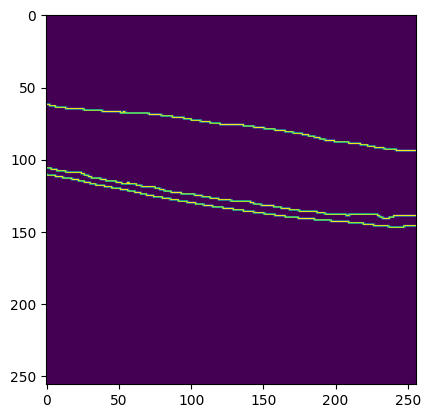

In [13]:
plt.imshow(y_train_1[2])

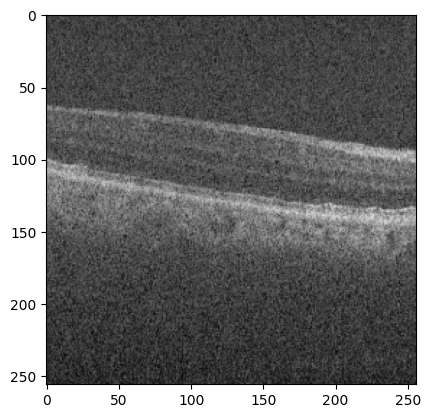

In [14]:
plt.imshow(x_train[2])

In [15]:
x_train_tensor = tf.convert_to_tensor(x_train_1)
y_train_tensor = tf.convert_to_tensor(y_train_1)

In [16]:
x_val_tensor = tf.convert_to_tensor(x_val_1)
y_val_tensor = tf.convert_to_tensor(y_val_1)

In [17]:
x_test_tensor = tf.convert_to_tensor(x_test_1)
y_test_tensor = tf.convert_to_tensor(y_test_1)

In [18]:
model = unet((256, 256, 3))
callbacks = [
    CSVLogger(filename="BatchNorm.csv",separator=',',append=False),
    ModelCheckpoint("Model.keras", monitor='val_dice_loss', save_best_only=True, verbose=1, mode="max")]
model.compile(Adam(learning_rate= 1e-4), loss= dice_loss, metrics= ['accuracy', iou_coef, dice_coef])

history = model.fit(x_train_tensor,
                    y_train_tensor,
                    validation_data = (x_val_tensor,y_val_tensor),
                    epochs=100,
                    verbose=1,
                    batch_size=16,
                    callbacks=callbacks
                   )

Epoch 1/100


2024-04-20 16:40:02.573631: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.11841, expected 2.65729
2024-04-20 16:40:02.573831: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 27392: 3.3488, expected 2.88768
2024-04-20 16:40:02.573895: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 38656: 3.55356, expected 3.09244
2024-04-20 16:40:02.574096: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65536: 3.62512, expected 2.96419
2024-04-20 16:40:02.574125: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65537: 4.47177, expected 3.81084
2024-04-20 16:40:02.574139: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65538: 5.40808, expected 4.74715
2024-04-20 16:40:02.574155: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65543: 5.33073, expected 4.66979
2024-04-20 16:40:02.574169: E ex

62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.7833 - dice_coef: 0.0781 - iou_coef: 0.0412 - loss: -0.0781

2024-04-20 16:41:27.925094: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.72144, expected 2.89031
2024-04-20 16:41:27.925157: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 5.65806, expected 4.82693
2024-04-20 16:41:27.925171: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 5.98376, expected 5.15263
2024-04-20 16:41:27.925186: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.6283, expected 5.79717
2024-04-20 16:41:27.925205: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.90088, expected 6.06975
2024-04-20 16:41:27.925220: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 6.70007, expected 5.86894
2024-04-20 16:41:27.925231: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 5.75339, expected 4.92226
2024-04-20 16:41:27.925243: E external/local_xla/xla/ser

63/63 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.7861 - dice_coef: 0.0792 - iou_coef: 0.0418 - loss: -0.0792 - val_accuracy: 0.9836 - val_dice_coef: 0.0292 - val_iou_coef: 0.0149 - val_loss: -0.0292
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 369ms/step - accuracy: 0.9525 - dice_coef: 0.1822 - iou_coef: 0.1006 - loss: -0.1822 - val_accuracy: 0.9836 - val_dice_coef: 0.0445 - val_iou_coef: 0.0233 - val_loss: -0.0445
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 369ms/step - accuracy: 0.9625 - dice_coef: 0.2203 - iou_coef: 0.1242 - loss: -0.2203 - val_accuracy: 0.9835 - val_dice_coef: 0.0588 - val_iou_coef: 0.0317 - val_loss: -0.0588
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9673 - dice_coef: 0.2520 - iou_coef: 0.1446 - loss: -0.2520 - val_accuracy: 0.9827 - val_dice_coef: 0.0665 - val_iou_coef: 0.0362 - val_loss: -0.0665
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9710 - dice_coef: 0.2866 - iou_coef: 0.1679 - loss: -0.2866 - val_accuracy